In [ ]:
# Module Imported 
%pip install ipykernel numpy pandas matplotlib scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score
)


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
from pathlib import Path

DATA_PATH = "dataSet/heart.csv"  
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()
print(df.info())
print("-----------------------------")
print(df.isna().sum())
print(df['ST_Slope'].head())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None
-----------------------------
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
Exercis

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [ ]:
import pandas as pd
from pathlib import Path

DATA_PATH = "dataSet/heart.csv"  
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()

expected = ['Age','Sex','ChestPainType','RestingBP','Cholesterol','FastingBS',
            'RestingECG','MaxHR','ExerciseAngina','Oldpeak','ST_Slope','HeartDisease']
missing = [c for c in expected if c not in df.columns]
if missing:
    raise ValueError(f"missing column: {missing}")

y = df['HeartDisease'].astype(int) #

X = df.drop(columns=['HeartDisease']).copy()

# Turn string categorical value into value 
# Sex, ChestPain(0-3)(ATA, NAP, ASY, TA), RestingECG (0-2)(Normal, ST, LVH), ExerciseAngina (0-1)(Yes, NO), ST_Slope(0-2)(Up, Flat, Down)

# Sex: M/F -> 1/0
X['Sex'] = X['Sex'].str.strip().map({'M': 1, 'F': 0}).astype(int)

# ExerciseAngina: Y/N -> 1/0
X['ExerciseAngina'] = X['ExerciseAngina'].str.strip().map({'Y': 1, 'N': 0}).astype(int)

# chestpaintype
chestPainType = {'ATA': 0, 'NAP': 1, 'ASY': 2, 'TA': 3}
X['ChestPainType'] = X['ChestPainType'].str.strip().map(chestPainType).astype(int)

# restingECG
restingECGType = {"Normal": 0, 'ST': 1, 'LVH': 2}
X['RestingECG'] = X['RestingECG'].str.strip().map(restingECGType).astype(int)

# st slope
slope = {'Up': 0, 'Flat': 1, 'Down': 2}
X['ST_Slope'] = X['ST_Slope'].str.strip().map(slope).astype(int)

# FastingBS make sure it is type int.
X['FastingBS'] = X['FastingBS'].astype(int)


out_dir = Path("processed")
out_dir.mkdir(exist_ok=True)

X_path = out_dir / "X_encoded.csv"
y_path = out_dir / "y.csv"
cols_path = out_dir / "feature_names.txt"

X.to_csv(X_path, index=False)
y.to_csv(y_path, index=False, header=['HeartDisease'])

with open(cols_path, "w", encoding="utf-8") as f:
    for c in X.columns:
        f.write(c + "\n")

print("Data cleaning and encoding completed.")
print(f"X_encoded shape: {X.shape} -> {X_path}")
print(f"y shape        : {y.shape} -> {y_path}")
print("Feature columns saved to:", cols_path)




Data cleaning and encoding completed.
X_encoded shape: (918, 11) -> processed\X_encoded.csv
y shape        : (918,) -> processed\y.csv
Feature columns saved to: processed\feature_names.txt


In [ ]:
# Split Dataset 
from sklearn.ensemble import RandomForestClassifier

# rf_model = RandomForestClassifier(
#     n_estimators=500,
#     criterion='entropy',
#     max_depth=None,
#     class_weight='balanced_subsample',
#     random_state=42,
#     n_jobs=-1
# )

svm_model = SVC(
    kernel='rbf',
    probability=True,
    random_state=42
)

In [ ]:
# stage 2, using Chi-square and and PCA
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2

num_cols = [
    "Age", "RestingBP", "Cholesterol",
    "MaxHR", "Oldpeak"
]

cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  
])


preprocessor = ColumnTransformer(
    transformers = [
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)
chi2_selector = Pipeline([
    ("scale_for_chi2", MinMaxScaler()),
    ("chi2", SelectKBest(score_func=chi2, k=9))
])

pca_reduce = PCA(n_components=6, random_state=42)

clf = Pipeline([
    ("preprocess", preprocessor),
    ("chi2", chi2_selector),
    ("pca", pca_reduce),
    ("model", svm_model)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size =0.2, random_state=42, shuffle=True, stratify=y
)
clf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'ChestPainType',
                                                   'FastingBS', 'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('chi2',
                 Pipeline(steps=[('scale_for_chi2', MinMaxScaler()),
                                 ('chi2',
                                  SelectKBest(k=9,
                                              score_func=<function chi2 at 0x000001D9573A8720>))])),
                ('pca', PCA(n_components=6, random_state=42)),
                ('model', SVC(probability=True, random_state=42))])

Eigenvalues for each component:
Component 1: 12007.262
Component 2: 641.076
Component 3: 327.276
Component 4: 69.592
Component 5: 1.282
Component 6: 0.623
Component 7: 0.532
Component 8: 0.233
Component 9: 0.167
Component 10: 0.159
Component 11: 0.134

 Number of components with eigenvalue > 1.0 : 5


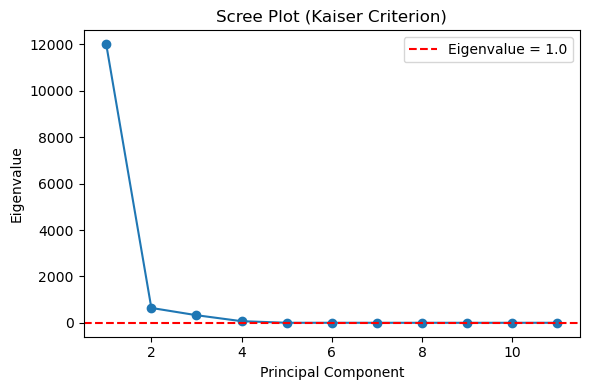

In [ ]:
# Keep all component that has eigenvalues > 1
pca = PCA()
pca.fit(X)

eigenvalues = pca.explained_variance_

print("Eigenvalues for each component:")
for i, val in enumerate(eigenvalues, 1):
    print(f"Component {i}: {val:.3f}")

n_above_one = np.sum(eigenvalues > 1)
print(f"\n Number of components with eigenvalue > 1.0 : {n_above_one}")

# graph 
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(eigenvalues)+1), eigenvalues, marker='o')
plt.axhline(y=1, color='r', linestyle='--', label='Eigenvalue = 1.0')
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.title("Scree Plot (Kaiser Criterion)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
param_grid = {
    "chi2__chi2__k" : [9,10, 11],
    "pca__n_components":[1,2,3,4,5,6,7,8],
    # "model__n_estimators":[100,200,300]
}
grid = GridSearchCV(
    estimator=clf, 
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs= -1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best Accuracy:", grid.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'chi2__chi2__k': 10, 'pca__n_components': 6}
Best Accuracy: 0.8623520641133166


In [ ]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

#Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8586956521739131
ROC-AUC: 0.8816953610712577

Confusion Matrix: 
 [[67 15]
 [11 91]]


Doing Cross_validation

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
def acc_recall_precision_F1(Yhat, Y):
    y = np.asarray(Y).ravel()
    yhat = np.asarray(Yhat).ravel()

    TP = np.sum((y == 1) & (yhat == 1))
    TN = np.sum((y == 0) & (yhat == 0))
    FP = np.sum((y == 0) & (yhat == 1))
    FN = np.sum((y == 1) & (yhat == 0))

    denom = TP + TN + FP + FN
    accuracy = (TP + TN) / denom if denom else 0.0

    precision = TP / (TP + FP) if (TP + FP) else 0.0
    recall    = TP / (TP + FN) if (TP + FN) else 0.0     
    F1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0

    return accuracy, recall, precision, F1


def confusion_matrix_display(yhat, y):
    
    cm = confusion_matrix(y_true=y, y_pred=yhat, labels=[1, 0])
    fig, ax = plt.subplots(figsize=(5, 4))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Positive", "Negative"]  #  [1, 0]
    )
    disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=False)
    ax.set_title("Type I and Type II error graph")
    plt.tight_layout()
    plt.show()



def roc_auc_display(y_scores, y_true):
    auc = roc_auc_score(y_true, y_scores)
    print("AUC:", auc)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()


def input_array_display(k, input_array=None, arrayname="array"):
    if not input_array:  # None 
        print("Warning: input_array is empty.")
        return 0

    x = np.arange(1, k + 1)
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(x, input_array, edgecolor='black', alpha=0.8)

    ax.set_title(f"{k}-Fold {arrayname} Scores", fontsize=12, fontweight='bold')
    ax.set_xlabel("Fold", fontsize=10)
    ax.set_ylabel(f"{arrayname} Score", fontsize=10)
    ax.set_xticks(x)
    ax.set_ylim(0, max(input_array) * 1.1 if max(input_array) > 0 else 1)

    ax.bar_label(bars, fmt='%.2f', padding=3, fontsize=9)
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.model_selection import  KFold
def cross_validation(k, X, Y):

    Y = np.asarray(Y).ravel()

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    Accuracy_list, Recall_list, Precision_list, F1_score_list = [], [], [], []

    yhat_all = np.zeros_like(Y, dtype=int)
    yscore_all = np.zeros_like(Y, dtype=float)  #  ROC/AUC
    cm_sum = np.array([[0, 0], [0, 0]], dtype=int)

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]   # iloc
        y_train, Y_test = Y[train_idx], Y[test_idx]



        clf = Pipeline([
            ("preprocess", preprocessor),
            ("chi2", chi2_selector),
            ("pca", pca_reduce),
            ("model", svm_model)
        ])
        clf.fit(X_train, y_train)

        yhat = clf.predict(X_test)
        yhat_all[test_idx] = yhat

        if hasattr(clf, "predict_proba"):
            yscore = clf.predict_proba(X_test)[:, 1]
        elif hasattr(clf, "decision_function"):
            yscore = clf.decision_function(X_test)
        else:
            yscore = yhat.astype(float)
        yscore_all[test_idx] = yscore

        accuracy_val, recall_val, precision_val, F1_val = acc_recall_precision_F1(yhat, Y_test)
        Accuracy_list.append(accuracy_val)
        Recall_list.append(recall_val)
        Precision_list.append(precision_val)
        F1_score_list.append(F1_val)

        cm_sum += confusion_matrix(Y_test, yhat, labels=[0, 1])

    input_array_display(k, Precision_list, "Precision")
    confusion_matrix_display(yhat_all, Y)         
    roc_auc_display(yscore_all, Y)              

    mean_acc = float(np.mean(Accuracy_list))
    mean_recall = float(np.mean(Recall_list))
    mean_precision = float(np.mean(Precision_list))
    mean_f1 = float(np.mean(F1_score_list))
    return mean_acc, mean_recall, mean_precision, mean_f1


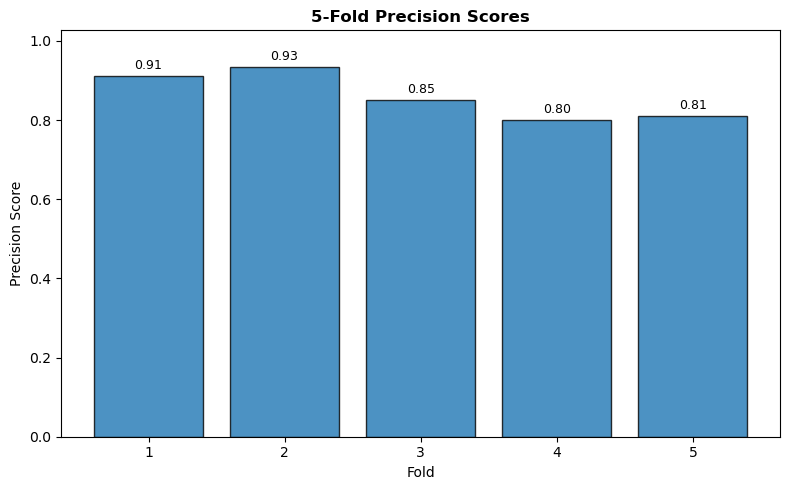

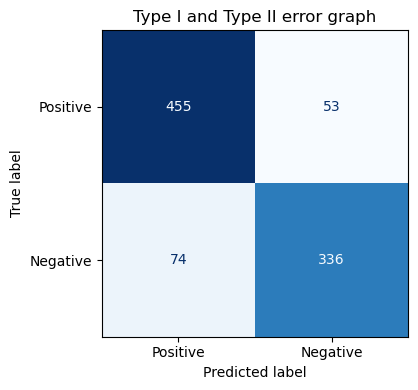

AUC: 0.8734660072978684


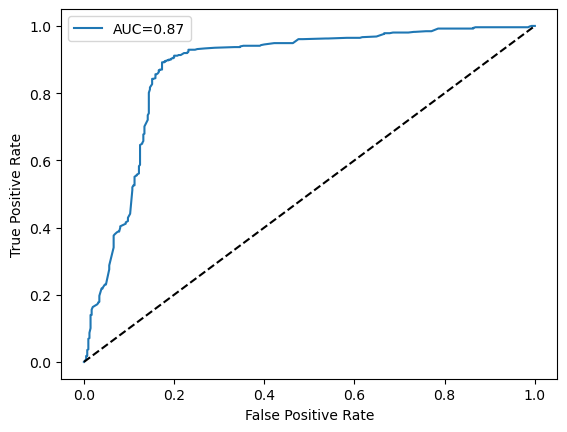

===== K-Fold Cross Validation Results =====
Accuracy : 0.8616
Recall   : 0.8979
Precision: 0.8610
F1-score : 0.8773


In [ ]:
mean_acc, mean_recall, mean_precision, mean_f1 = cross_validation(5,X,y)
print("===== K-Fold Cross Validation Results =====")
print(f"Accuracy : {mean_acc:.4f}")
print(f"Recall   : {mean_recall:.4f}")
print(f"Precision: {mean_precision:.4f}")
print(f"F1-score : {mean_f1:.4f}")
print("============================================")

